# На цей раз вам потрібно виконати завдання з цього [ноутбука]("https://colab.research.google.com/drive/1XpRovHlJJ16FZojZd8-9ci1pyiUiYogx?usp=sharing#scrollTo=Ml3jlosnF0cm"). Для вирішення запропонованих завдань вам також потрібно завантажити [датасет]("https://drive.google.com/file/d/1-4wgz9AFXrD3tZfqHJLMhCmy4BUzAX96/view?usp=sharing") з даними про оренду велосипедів.

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [15]:
URL = "https://drive.usercontent.google.com/download?id=1-4wgz9AFXrD3tZfqHJLMhCmy4BUzAX96&export=download"

df = pd.read_csv(URL, header=0) # put your code here
if len(df) == 0:
    print("Error: file not found")
    raise ValueError

df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

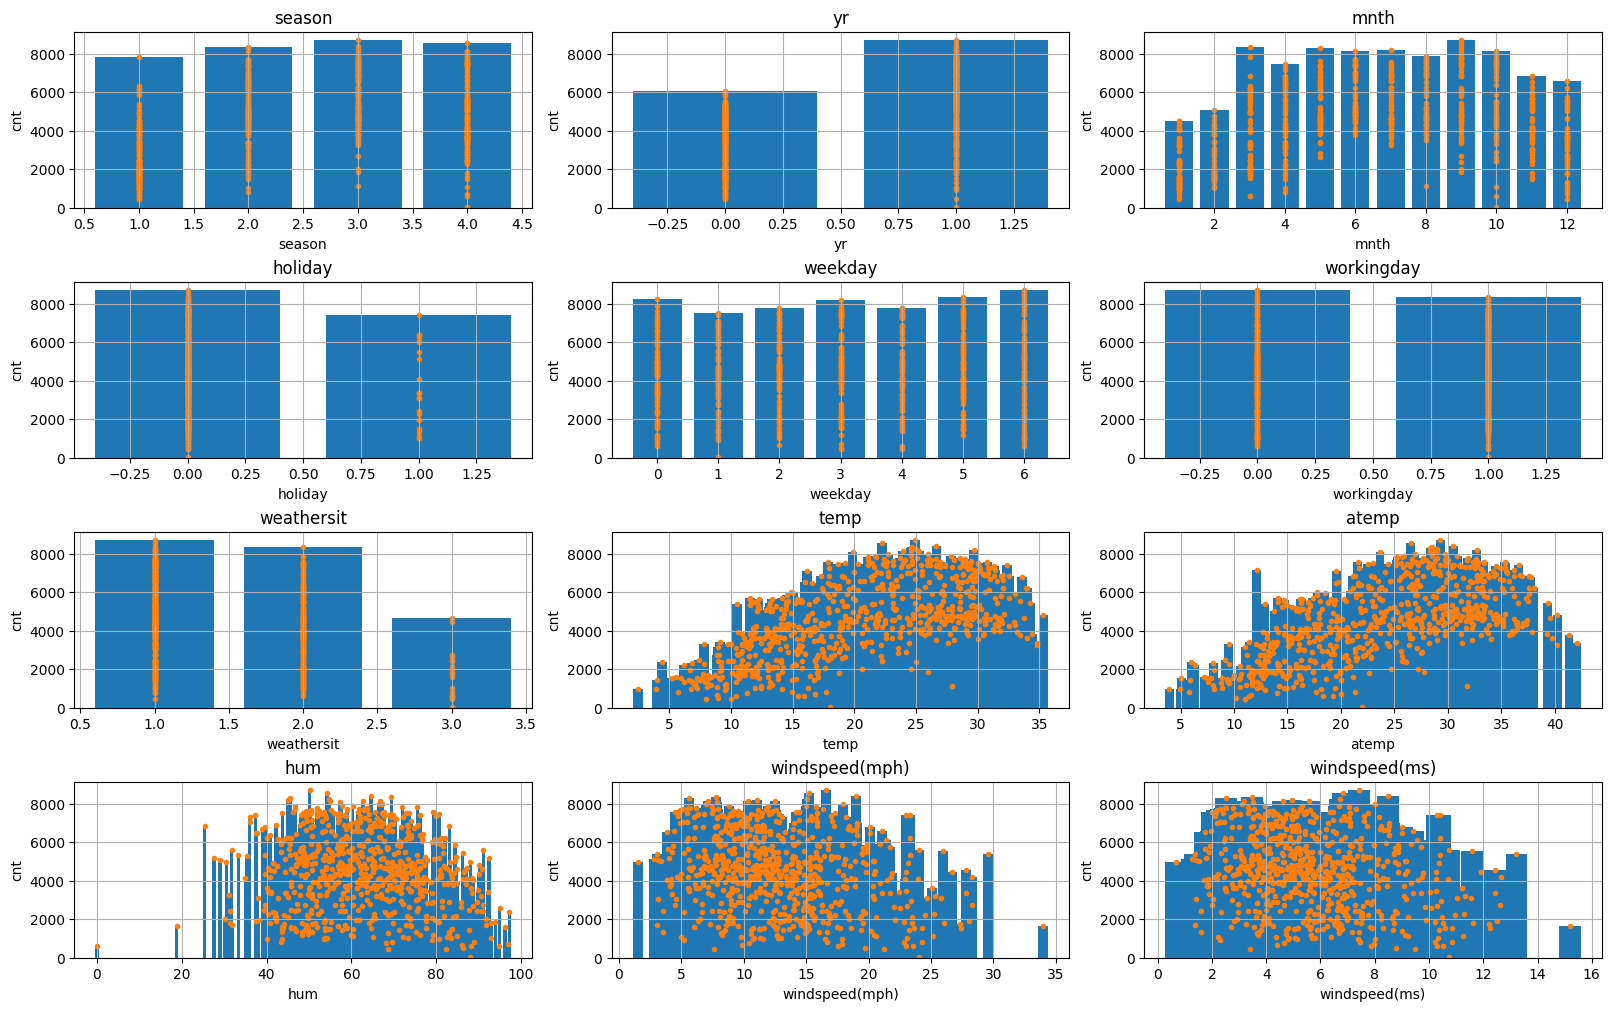

In [26]:
# Put you code here
# main_year = 2011

df_features_columns = df.columns[:-1]
df_target_column = df.columns[-1]


plot_cols = 3
plot_rows = len(df_features_columns) // plot_cols


fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(16, 10), layout="constrained")

for ax, feature in zip(axs.flatten(), df_features_columns):
    ax.bar(
        df[feature],
        df[df_target_column],
    )
    ax.scatter(
        df[feature],
        df[df_target_column],
        marker=".",
    )
    ax.set_xlabel(feature)
    ax.set_ylabel(df_target_column)
    ax.set_title(feature)
    ax.grid()

plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця? 
    $\\$ __Відповідь__: В теплі місяці прокатів більш ниж у хододні за порою року залежно від розсташуваяння прокату (судячи з результатів можно припустити що данні приведени для західноі европи)
2. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно?
    $\\$ __Відповідь__: temp(atemp), також може не так виразливо windspeed

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [30]:
# Put your code here
# df[df_features_columns].corr()
df[df_features_columns].corrwith(df[df_target_column])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr: